# Aprendizaje Automático para Datos en Grafos - Laboratorio 3
## Introducción a modelos generativos, representation learning y detección de comunidades.

En este laboratorio trataremos de ganar cierta intuición de algunos modelos clásicos para grafos no dirigidos y sin pesos. En particular el **Erdös-Rényi** (ER), **Stochastic Block Models** (SBM) y el más general **Random Dot Product Graph** (RDPG). Este último es lo que se denomina un modelo de *posiciones latentes*, donde cada nodo $i=1,\ldots,n$ tendrá asociado un cierto vector $\mathbf{x}_i\in\mathbb{R}^d$ y la probabilidad de que un par de nodos $i$ y $j$ estén conectados es una cierta función $\kappa(\mathbf{x}_i,\mathbf{x}_j)$. En el caso particular del RDPG, esta función es el producto interno $\langle\mathbf{x}_i,\mathbf{x}_j\rangle$.

Lo anterior es un caso particular de **embeddings de nodos**. Es decir, cada nodo se representa con un vector de dimensión $d\ll n$, a partir de los cuales,  en cierto sentido, se puede "recuperar" el grafo. Para ser más precisos, en un RDPG si $\mathbf{X}\in\mathbb{R}^{n\times d}$ son los vectores fila $\mathbf{x}_i^\top$ apilados, entonces se cumple que, entre todas las matrices de rango $d$ semi-definidas positivas, $\mathbf{X}\mathbf{X}^T$ minimiza $||\mathbf{A}-\mathbf{X}\mathbf{X}^T||^2_F$ (siendo $\mathbf{A}$ la matriz de adyacencia del grafo). Observar que la matriz $\mathbf{X}\mathbf{X}^T$ contiene en la entrada $(i,j)$ el producto interno entre las posiciones latentes de los nodos $i$ y $j$. Lo que se busca con la minimización entonces es encontrar estas posiciones latentes, de forma que las conexiones observadas en $\mathbf{A}$ sean bien aproximadas por los productos internos correspondientes.

Si cada nodo queda representado con un vector, entonces es natural realizar clustering a partir de esta representación. En particular, usaremos el modelo RDPG para **detectar comunidades** en un grafo. Además de networkx, usaremos **graspologic**, una biblioteca específica para RDPG (https://microsoft.github.io/graspologic/latest/index.html).

In [ ]:
# Instalo graspologic
!pip install graspologic

In [1]:
# importamos algunas bibliotecas que vamos a usar
import networkx as nx
import graspologic as gp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE



/Users/joflaherty/Workspace/personal/maestria/AA-grafos/lab3/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Grafos Erdös-Rényi

Los grafos aleatorios ER son quizá lo más sencillos de especificar. Cada par de nodos está conectado con una cierta probabilidad $p$, independiente para todos los pares de nodos.

La siguiente celda genera un ER con cierta cantidad de nodos `n` y probabilidad de conexión `p` y dibuja el grafo resultante.
1. Verifique que a partir de cierto valor de $p$ (que a su vez dependerá de $n$) el grafo es conexo.

10.0


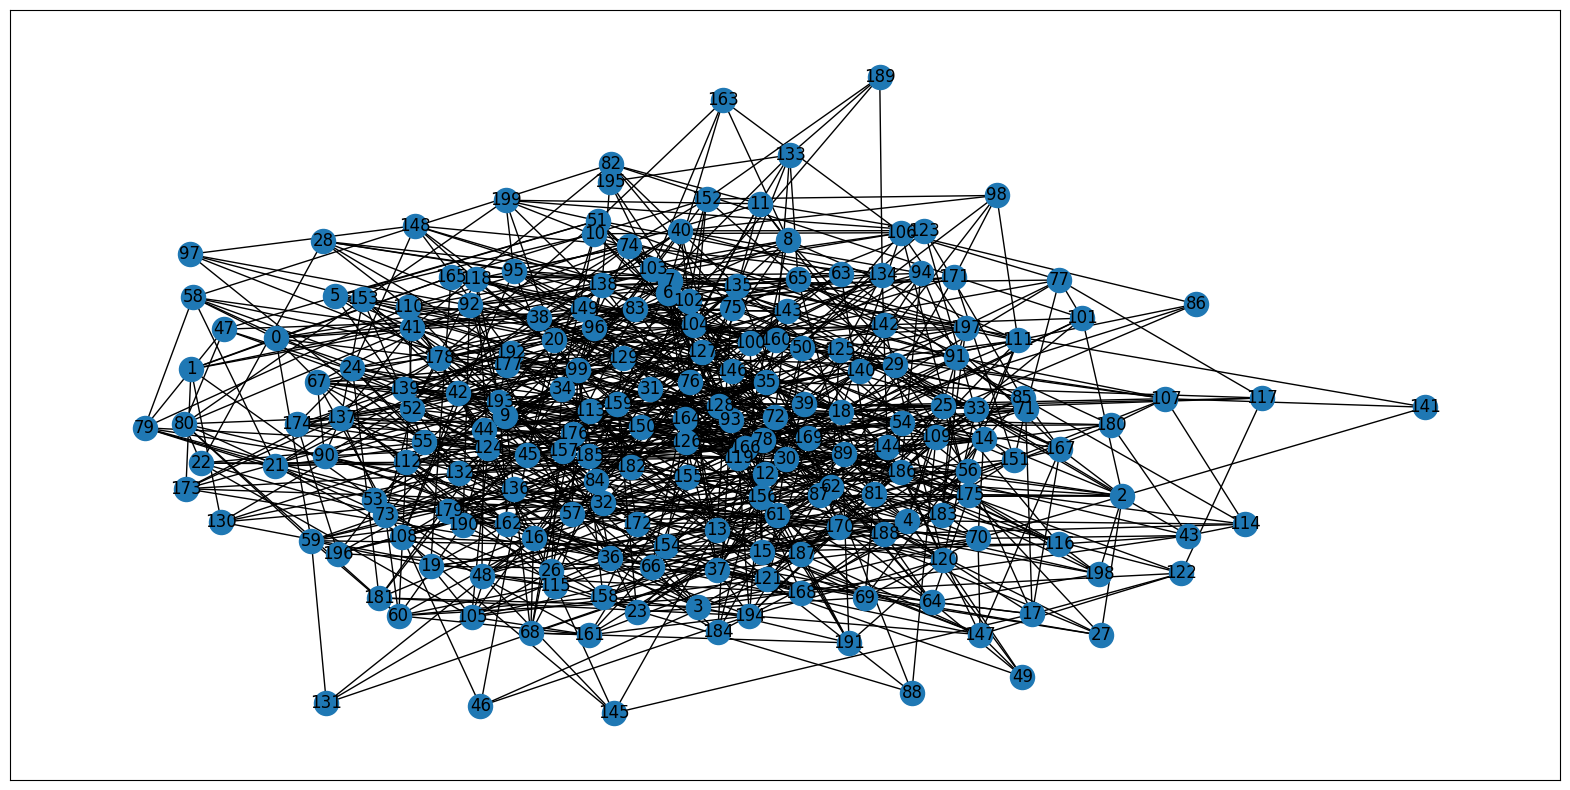

Text(0.5, 1.0, 'Matriz de adyacencia de G_er')

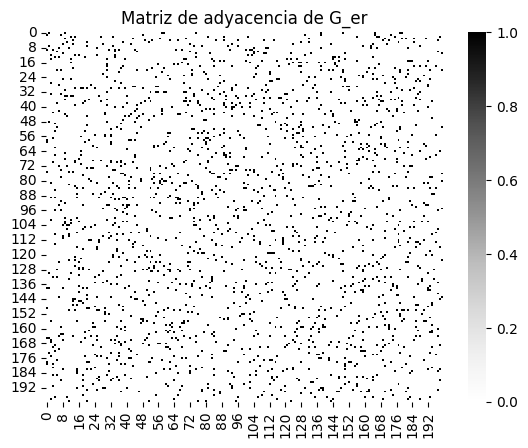

In [2]:
n = 200
p = 0.05

print(n*p)
# genero el grafo
G_er = nx.generators.random_graphs.erdos_renyi_graph(n=n,p=p)

# lo dibujo
plt.figure(figsize=(20,10))
nx.draw_networkx(G_er)
plt.show()
# y también ploteo su matriz de adyacencia
sns.heatmap(nx.to_numpy_array(G_er), cmap='Greys')
plt.title('Matriz de adyacencia de G_er')

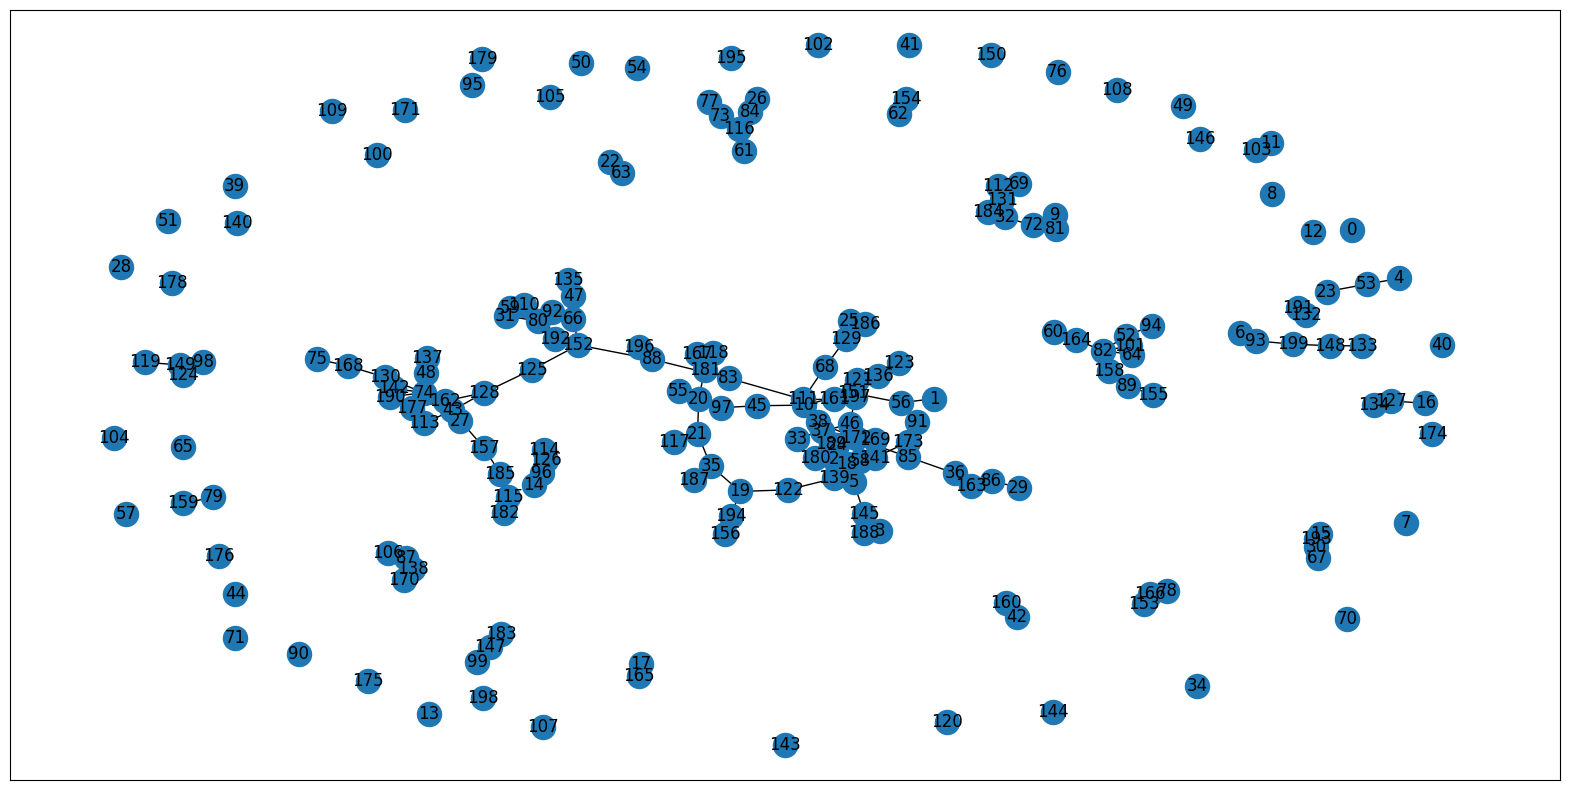

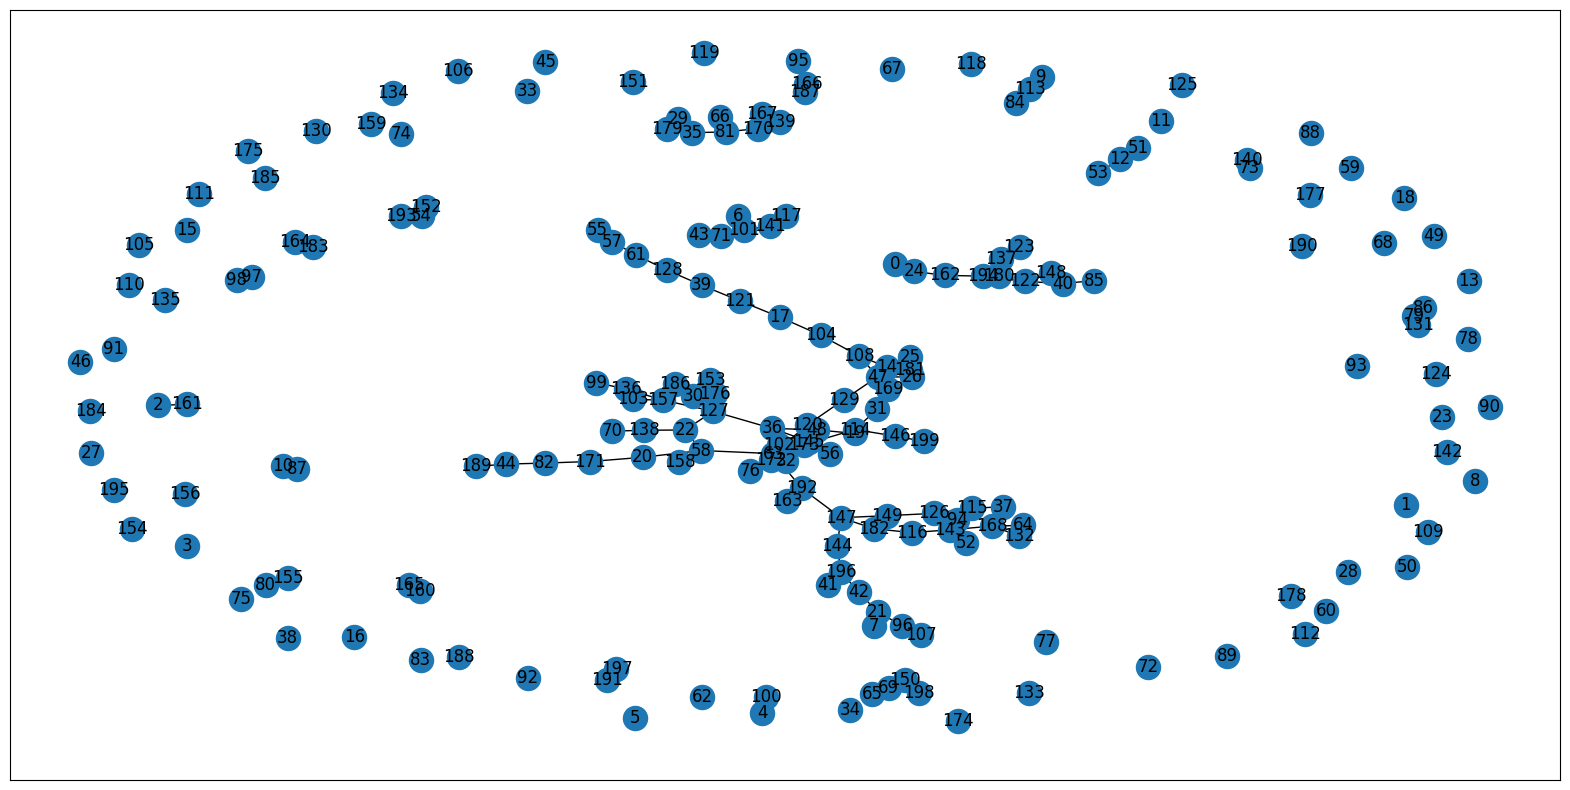

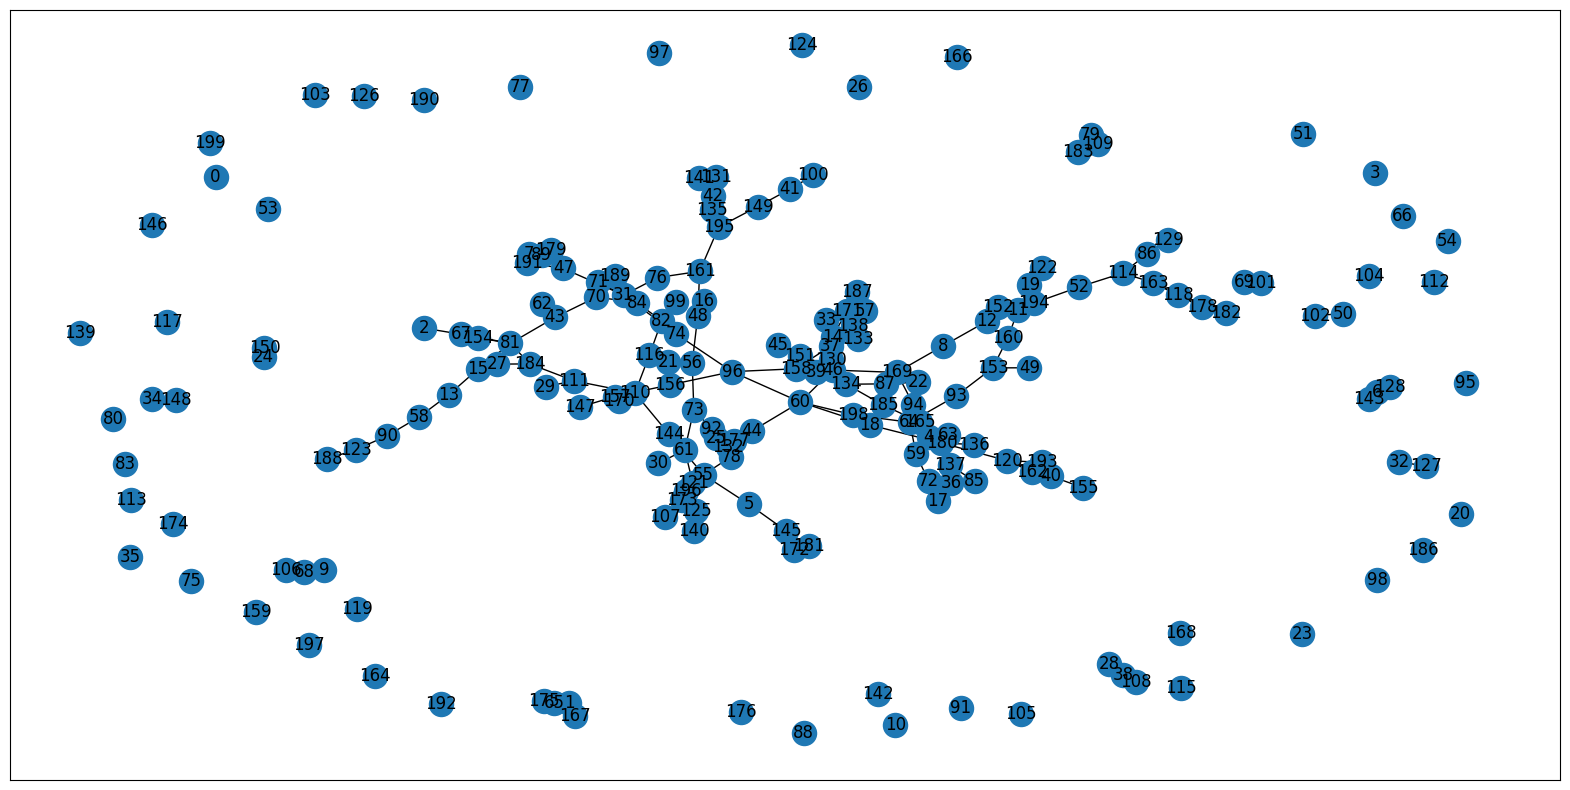

In [ ]:
n = 200
th = np.log(n)/n
# for p in [th - 0.01, th, th + 0.01]:
for p in [1.2/ 200]:
    for i in range(3):
    # genero el grafo
        G_er = nx.generators.random_graphs.erdos_renyi_graph(n=n,p=p)

        # lo dibujo
        plt.figure(figsize=(20,10))
        nx.draw_networkx(G_er)
        plt.savefig(f'informe/images/erdos_renyi/n200_p{p}_{i}.png')

## Grafos Stochastic Block Model

Aunque es un objeto matemáticamente muy interesante (con efectos de transición de fase como el que vimos recién) está claro que el modelo ER es un tanto básico y no incluye varias de las características de grafos "reales". En particular, en lo que respecta a este laboratorio, no se forman comunidades entre nodos.

El modelo más clásico para incluir estos fenómenos es el SBM y sus variantes. En su formulación más sencilla cada nodo pertenece a una de $C$ comunidades y la existencia de una arista entre un par de nodos es un evento independiente del resto de las aristas y de probabilidad $\mathbf{Q}_{c_i,c_j}$ (donde $\mathbf{Q}\in\mathbb{R}^{C\times C}$ es una cierta matriz de probabilidad y $c_i$,$c_j$ son las comunidades de los nodos $i$,$j$ respectivamente).

La siguiente celda genera un grafo con un par de comunidades. Entre nodos de la misma comunidad la conexión es bastante fuerte, y la conectividad es bastante baja entre nodos de distintas comunidades. Jugue un poco con los dos parámetros disponibles: `n` y `Q`.

2. Usando dos comunidades para simplificar la visualización ¿qué diferencia cualitativa hay entre el caso que `Q` tenga todos los valores propios positivos y cuando algunos valores propios son negativos?
3. En particular, use los siguientes parámetros `n=[45, 5, 45, 5]` y $Q = \left( \begin{smallmatrix}0.05 & 0.9 & 0 & 0\\ 0.9 & 0.8& 0 & 0.5 \\ 0 & 0& 0.05 & 0.9 \\ 0& 0.5& 0.9 & 0.9\end{smallmatrix}\right)$. ¿Cuántas comunidades hay?

Valores propios de Q: [0.42071068 0.27928932]


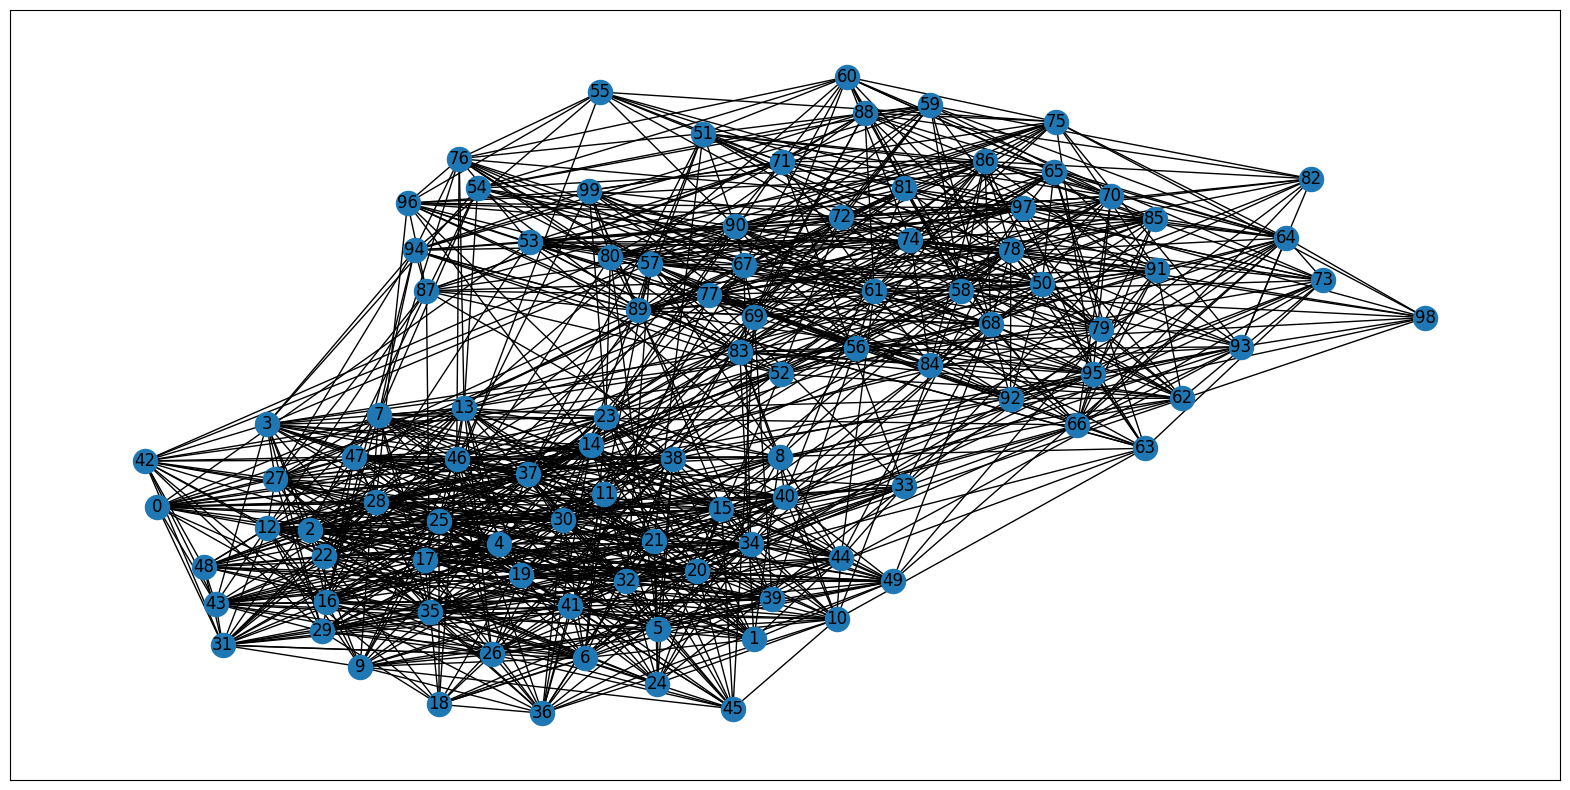

Text(0.5, 1.0, 'Matriz de adyacencia de G_sbm')

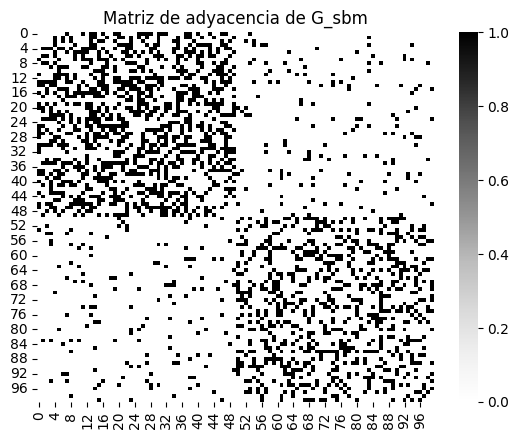

In [134]:
n = [50, 50]
# atención que Q tiene que ser simétrico en este caso que vamos a generar grafos simétricos
Q = [[0.4, 0.05],
     [0.05, 0.3]]
# vap negativo (comunidad inexistente)
# Q = [[0.8, 0.5],
#      [0.5, 0.01]]
# Q = [[0.9, 0.05], [0.05, 0.9]]
# Mientras más positivo el vap, más fuertemente conectada la comunidad

# calculo e imprimo los valores propios para chequear y no hacer macanas...
w = np.linalg.eigvals(Q)
print("Valores propios de Q: "+str(w))

# y hago lo mismo que en la celda anterior.
G_sbm = nx.stochastic_block_model(sizes=n, p=Q)

plt.figure(figsize=(20,10))
nx.draw_networkx(G_sbm)
plt.show()
sns.heatmap(nx.to_numpy_array(G_sbm), cmap='Greys')
plt.title('Matriz de adyacencia de G_sbm')

Valores propios de Q: [ 1.81215756  1.11096333 -0.71345711 -0.40966378]


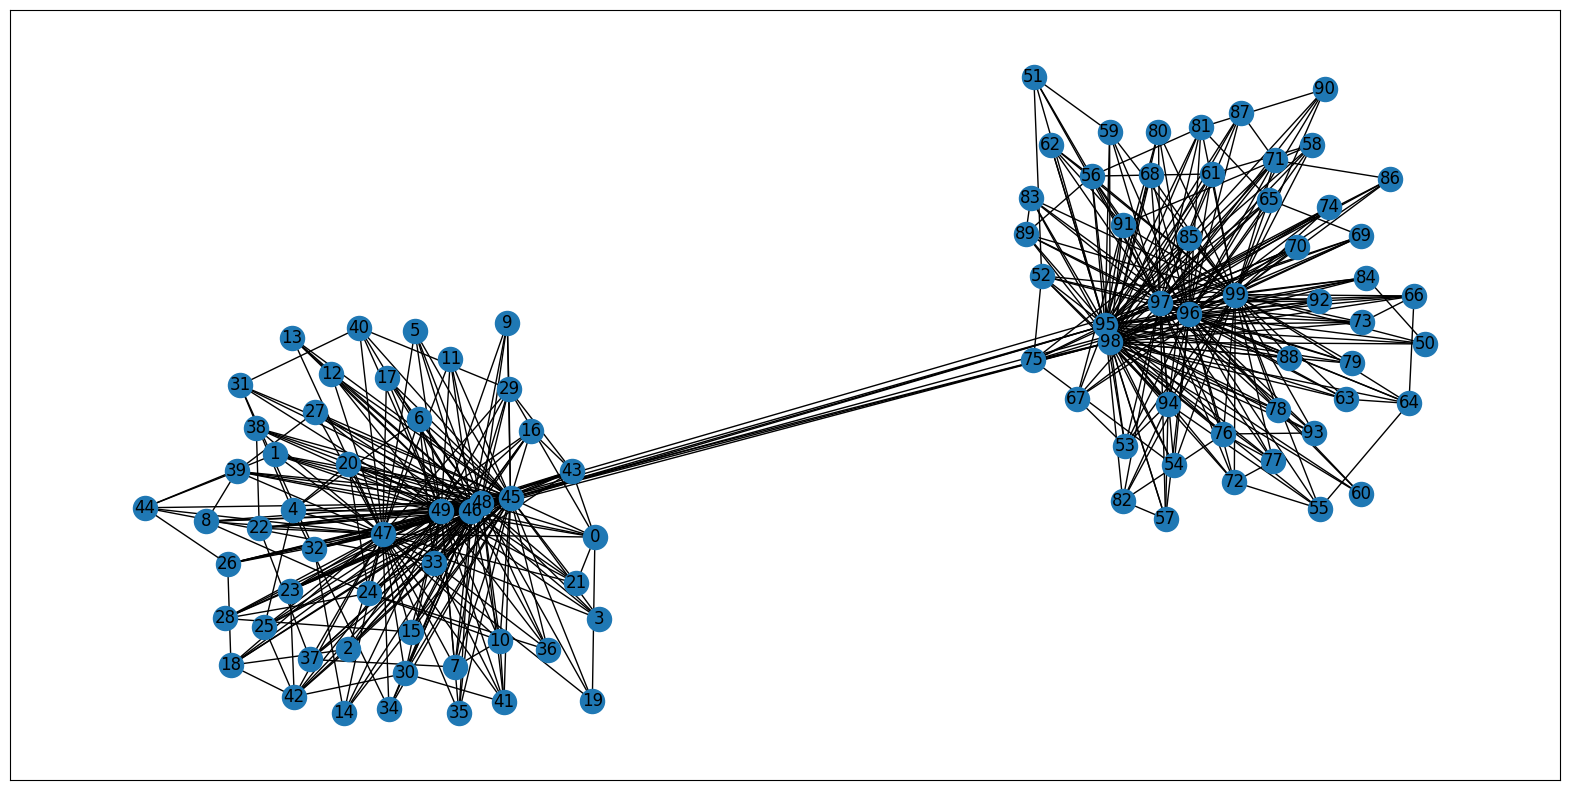

Text(0.5, 1.0, 'Matriz de adyacencia de G_sbm')

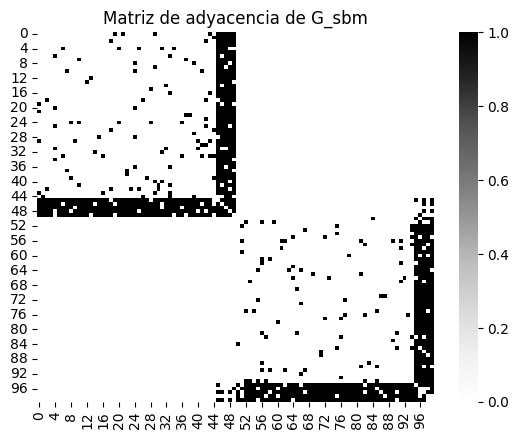

In [135]:
n=[45, 5, 45, 5]
# atención que Q tiene que ser simétrico en este caso que vamos a generar grafos simétricos
Q = [
     [0.05, 0.9, 0.0, 0.0],
     [0.9, 0.8, 0.0, 0.5],
     [0.0, 0.0, 0.05, 0.9],
     [0.0, 0.5, 0.9, 0.9]
]

# calculo e imprimo los valores propios para chequear y no hacer macanas...
w = np.linalg.eigvals(Q)
print("Valores propios de Q: "+str(w))

# y hago lo mismo que en la celda anterior.
G_sbm = nx.stochastic_block_model(sizes=n, p=Q)

plt.figure(figsize=(20,10))
nx.draw_networkx(G_sbm)
plt.show()
sns.heatmap(nx.to_numpy_array(G_sbm), cmap='Greys')
plt.title('Matriz de adyacencia de G_sbm')

## Grafos Random Dot-Product Graph: definición

El modelo RDPG (y sus variantes) es relativamente nuevo y como veremos es una generalización del SBM (y por lo tanto del ER). De todas formas, sigue siendo un modelo donde la existencia de cada arista es independiente del resto. Definamos entonces la matriz $\mathbf{P}\in\mathbb{R}^{n\times n}$, donde la entrada $\mathbf{P}_{i,j}$ indica la probabilidad de la existencia de una arista entre los nodos $i,j$ (donde ignoraremos la diagonal). Como comentamos en la introducción, cada nodo $i=1,\ldots,n$ tendrá asociado un vector $\mathbf{x}_i\in\mathbb{R}^d$ y la probabilidad de que un par de nodos $i$ y $j$ estén conectados es el producto interno $\langle\mathbf{x}_i,\mathbf{x}_j\rangle$. De forma compacta, si $\mathbf{X}\in\mathbb{R}^{n\times d}$ son los vectores fila $\mathbf{x}_i^\top$ apilados, entonces $\mathbf{P}=\mathbf{X}\mathbf{X}^\top$.

4. ¿Cómo se puede generar un grafo ER con probabilidad $p$ a partir de un RDPG? Dicho de otra forma, ¿cuánto valdrían los $\mathbf{x}_i$ para un grafo ER de parámetro $p$?
5. ¿Y un grafo SBM? ¿Cómo haría detección de comunidades usando el modelo RDPG en este caso?
**Observación**: dado un grafo SBM con una matriz de probabilidad de conexiones entre comunidades $\mathbf{Q} \in \mathbb{R}^{C\times C}$, es posible escribir la matriz de probabilidad de conexiones entre nodos $\mathbf{P}\in \mathbb{R}^{N \times N}$ en función de $\mathbf{Q}$ y de una matriz $\mathbf{Z}\in \mathbb{R}^{N \times C}$, con entradas $Z_{ij} = 1$ si el nodo $i$ pertenece a la comunidad $j$, o $Z_{ij}=0$ en caso contrario.
6. ¿Se puede generar cualquier grafo SBM? Por ejemplo, ¿el de la pregunta 3? Pruebe que bajo el modelo RDPG $\mathbf{P}$ debe ser semidefinida positiva, algo que no cumple la $\mathbf{P}$ del grafo de la pregunta 3. El siguiente artículo discute este problema y su (relativamente sencilla) solución: https://arxiv.org/abs/1709.05506. **Observación**: en la pregunta 3. les damos la matriz de probabilidad de conexiones entre comunidades $\mathbf{Q} \in \mathbb{R}^{C\times C}$, mientras que la pregunta 6. se refiere a la matriz de probabilidad de conexiones entre nodos $\mathbf{P} \in \mathbb{R}^{N\times N}$.

#### 4

En ER, la probabilidad de que $x_i$ y $x_j$ esten conectados es $p$. Entonces $P = p \mathbf{1}_{n\times n}$

$\langle x_i, x_j\rangle = p$, podemos tomar $x_i = \sqrt{p}$ 

$X = [\sqrt{p}, \dots, \sqrt{p}]^\top$


#### 5

$Q_{c\times c}$

$$
Z\in\mathbb{R}^{N\times C}, Z_{i,j} = \left\lbrace
\begin{aligned}
    1, & \quad\text{si i y j pertenecen a la misma comunidad} \\
    0, & \quad\text{en otro caso}
\end{aligned}\right.
$$

$$
P = Z \cdot Q \Rightarrow XX^\top = ZQ
$$


#### 6

Para que $ZQ$ sea $XX^\top$, $ZQ$ tiene que ser una matriz de Gram. Por definición, estas matrices requieren ser semidefinidas positivas, por lo que si la matriz tiene un vap negativo no es posible la descomposición.

## Grafos Random Dot-Product Graph: inferencia

La aplicación que nos interesa en este caso es detectar comunidades dentro de un grafo. Por lo tanto, dado un grafo $G$ y su matriz de adyacencia $\mathbf{A}$, nos enfocamos ahora en cómo estimar la matriz $\mathbf{X}$. Dado que $\mathbb{E}[\mathbf{A}]=\mathbf{P}=\mathbf{X}\mathbf{X}^\top$, intuitivamente tiene sentido hallar la mejor aproximación de rango $d$ de la matriz $\mathbf{A}$.

Por lo tanto, la estimación $\hat{\mathbf{X}}$ se hallaría resolviendo
> $$\hat{\mathbf{X}}=\underset{\mathbf{X}: \text{ rango} (\mathbf{X}\mathbf{X}^\top)=d}{\mathrm{argmin}}||\mathbf{A}-\mathbf{X}\mathbf{X}^\top||^2_F.$$

La solución de este problema es relativamente sencilla. Dado que $\mathbf{A}$ es simétrica y real, tiene una descomposición espectral de la forma $\mathbf{A}=\mathbf{Q}\boldsymbol{\Lambda}\mathbf{Q}^\top$. La mejor aproximación de rango $d$ de la matriz $\mathbf{A}$ se puede encontrar ordenando los valores propios por magnitud y usando solo los $d$ mayores. Sea $\hat{\mathbf{Q}}$ y $\hat{\mathbf{\Lambda}}$ el correspondiente "recorte":
> $$\mathbf{A} \approx \hat{\mathbf{Q}}\hat{\boldsymbol\Lambda}\hat{\mathbf{Q}}^\top=\hat{\mathbf{Q}}\sqrt{\hat{\boldsymbol\Lambda}}\sqrt{\hat{\boldsymbol\Lambda}}\hat{\mathbf{Q}}^\top=\hat{\mathbf{Q}}\sqrt{\hat{\boldsymbol\Lambda}}\left(\hat{\mathbf{Q}}\sqrt{\hat{\boldsymbol\Lambda}}\right)^\top=\hat{\mathbf{X}}\hat{\mathbf{X}}^\top.$$

La expresión anterior explicita la necesidad de que los $d$ mayores (en valor absoluto) valores propios de $\mathbf{A}$ sean positivos.

### Usando `graspologic` y ganando intuición con grafos ER.

Para hallar esta descomposición (y en particular estimar $d$) vamos a usar la biblioteca `graspologic`. La siguiente celda usa el grafo `G_er` generado antes y estima la matriz de las posiciones latentes.

7. ¿Cómo cambia la precisión de las estimaciones de los $\mathbf{x}_i$ a medida que varía $p$ y $n$?
8. ¿Y la del producto $\hat{\mathbf{X}}\hat{\mathbf{X}}^\top$?
9. La celda también grafica los valores propios de la matriz de adyacencia ordenados por su valor absoluto. ¿Cómo estimaría $d$ a partir de esta gráfica?

En vez de usar el parámetro `n_components` en el constructor `gp.embed.AdjacencySpectralEmbed`, use el parámetro `n_elbows=1`. Lea la documentación de la función y verifique que se obtiene lo esperado.

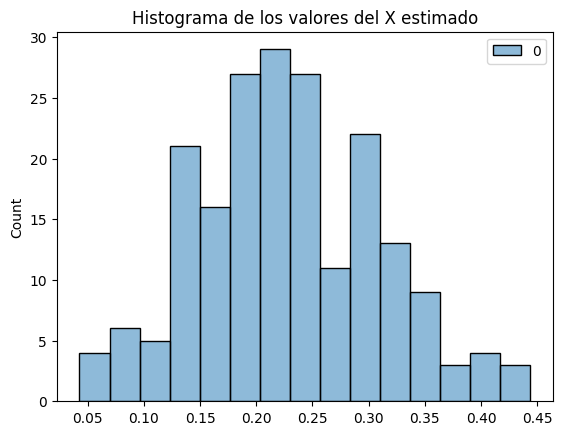

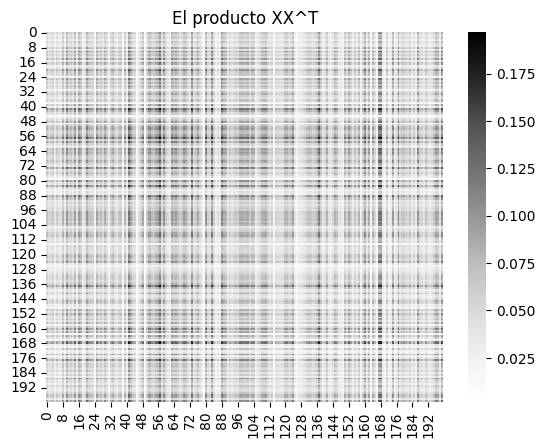

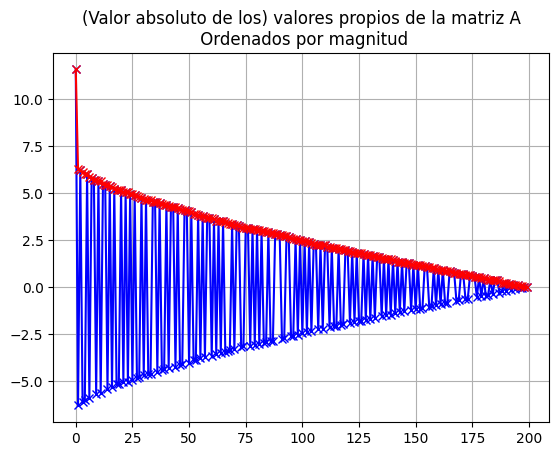

In [149]:
#####################################
# algunos ejemplos usando grafos ER
#####################################

# repito el código de generación del grafo por comodidad en las pruebas
n = 200
p = 0.05
G_er = nx.generators.random_graphs.erdos_renyi_graph(n=n,p=p)

# armo el objeto que estimará el embedding con dimensión d=1 (porque ya sé)
ase = gp.embed.AdjacencySpectralEmbed(n_components=1)

Xhat = ase.fit_transform(G_er)

plt.figure()
sns.histplot(Xhat, bins=15)
plt.title('Histograma de los valores del X estimado')
plt.figure()
sns.heatmap(Xhat@Xhat.T, cmap='Greys')
plt.title('El producto XX^T')
plt.figure()

# calculo los valores propios de A y los ordeno por magnitud (y en caso de empate, por signo).
w = np.linalg.eigvals(nx.to_numpy_array(G_er))
wabs = np.array(list(zip(-np.abs(w), -np.sign(np.real(w)))), dtype=[('abs', 'f4'), ('sign', 'i4')])
w = w[np.argsort(wabs,order=['abs','sign'])]
plt.plot(w,'x-', color='blue')
plt.plot(np.abs(w),'x-', color='red')
plt.title('(Valor absoluto de los) valores propios de la matriz A\n Ordenados por magnitud')
plt.grid()



(200, 1)


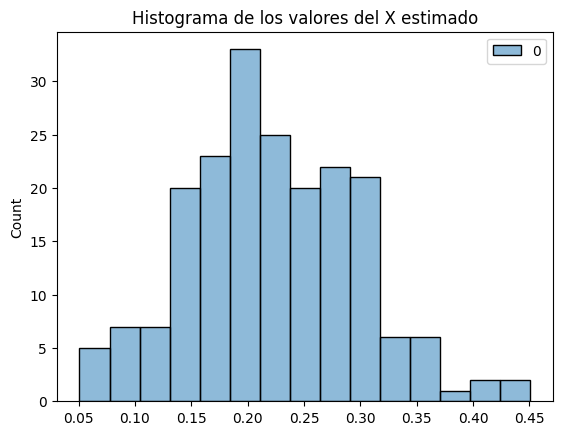

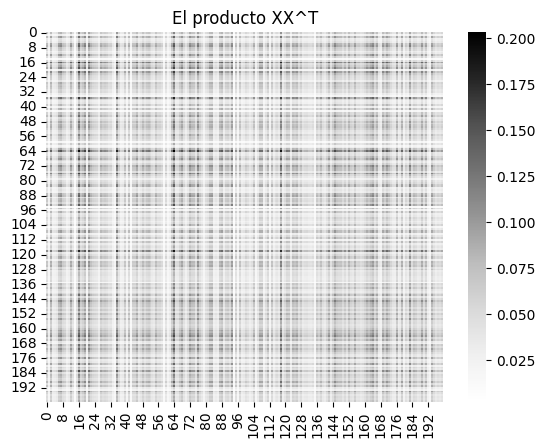

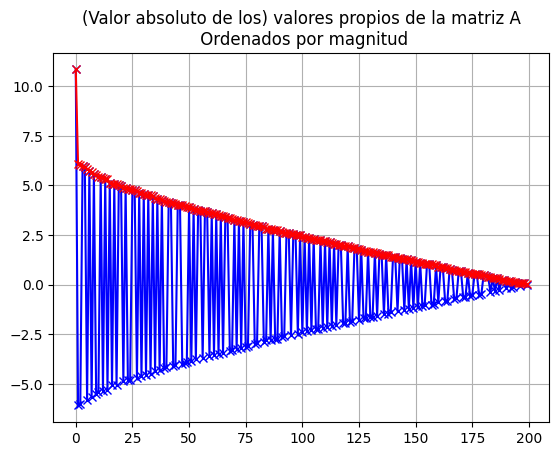

In [147]:
#####################################
# algunos ejemplos usando grafos ER
#####################################

# repito el código de generación del grafo por comodidad en las pruebas
n = 200
p = 0.05
G_er = nx.generators.random_graphs.erdos_renyi_graph(n=n,p=p)

# armo el objeto que estimará el embedding con dimensión d=1 (porque ya sé)
ase = gp.embed.AdjacencySpectralEmbed(n_elbows=1)

Xhat = ase.fit_transform(G_er)
print(Xhat.shape)
plt.figure()
sns.histplot(Xhat, bins=15)
plt.title('Histograma de los valores del X estimado')
plt.figure()
sns.heatmap(Xhat@Xhat.T, cmap='Greys')
plt.title('El producto XX^T')
plt.figure()

# calculo los valores propios de A y los ordeno por magnitud (y en caso de empate, por signo).
w = np.linalg.eigvals(nx.to_numpy_array(G_er))
wabs = np.array(list(zip(-np.abs(w), -np.sign(np.real(w)))), dtype=[('abs', 'f4'), ('sign', 'i4')])
w = w[np.argsort(wabs,order=['abs','sign'])]
plt.plot(w,'x-', color='blue')
plt.plot(np.abs(w),'x-', color='red')
plt.title('(Valor absoluto de los) valores propios de la matriz A\n Ordenados por magnitud')
plt.grid()



### Ganando intuición usando grafos SBM

La siguiente celda repite los experimentos anteriores pero para un grafo SBM. En este caso la dimensión del embedding será mayor a 1, por lo que se graficarán los puntos correspondientes a las dos primeras dimensiones en vez del histograma. Verifique que su repuesta a la pregunta 5 debería funcionar.

10. Dados dos nodos $i,j$, ¿qué representa el ángulo entre $\mathbf{x}_i$ y $\mathbf{x}_j$ respecto a su probabilidad de conexión?
11. ¿Y la magnitud de $\mathbf{x}_i$?

<Figure size 640x480 with 0 Axes>

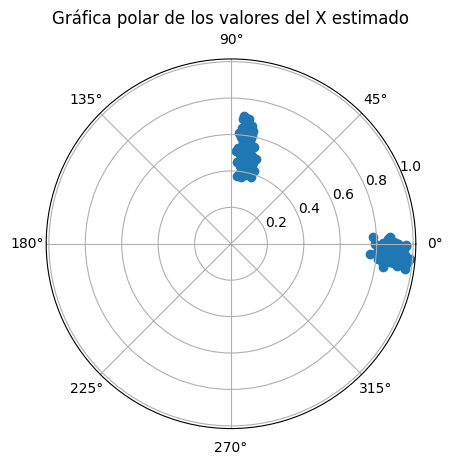

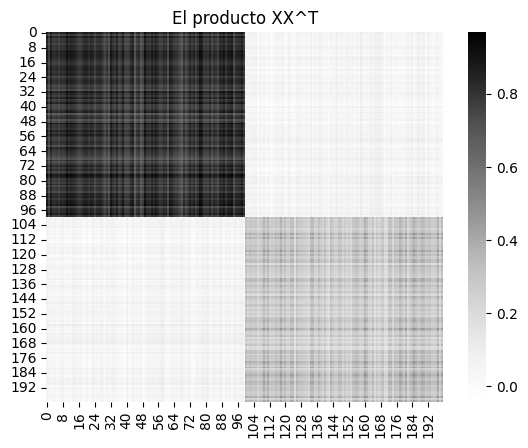

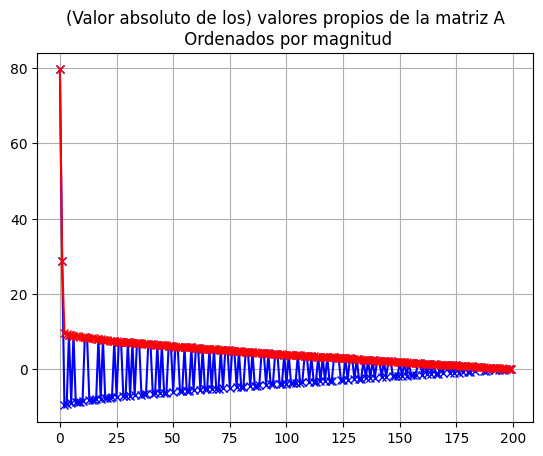

In [157]:
#####################################
# algunos ejemplos usando grafos SBM
#####################################

# repito el código de generación del grafo por comodidad en las pruebas
n = [100, 100]
Q = [[0.8, 0.05],
     [0.05, 0.3]]
G_sbm = nx.stochastic_block_model(sizes=n, p=Q)

# armo el objeto que estimará el embedding con dimensión n_elbows=2 (valor por defecto)
ase = gp.embed.AdjacencySpectralEmbed(n_elbows=2)

Xhat = ase.fit_transform(G_sbm)

plt.figure()
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
complejo = Xhat[:,0]+1j*Xhat[:,1]
ax.scatter(np.angle(complejo),np.abs(complejo))
plt.title('Gráfica polar de los valores del X estimado')
plt.figure()
sns.heatmap(Xhat@Xhat.T, cmap='Greys')
plt.title('El producto XX^T')
plt.figure()

# calculo los valores propios de A y los ordeno por magnitud (y en caso de empate, por signo).
w = np.linalg.eigvals(nx.to_numpy_array(G_sbm))
wabs = np.array(list(zip(-np.abs(w), -np.sign(np.real(w)))), dtype=[('abs', 'f4'), ('sign', 'i4')])
w = w[np.argsort(wabs,order=['abs','sign'])]
plt.plot(w,'x-', color='blue')
plt.plot(np.abs(w),'x-', color='red')
plt.title('(Valor absoluto de los) valores propios de la matriz A\n Ordenados por magnitud')
plt.grid()

In [ ]:
print(Xhat @ Xhat.T)

[[0.90240026 0.79064576 0.89981941 ... 0.07679985 0.04168079 0.04344023]
 [0.79064576 0.69302502 0.78901808 ... 0.05547739 0.02891736 0.02713424]
 [0.89981941 0.78901808 0.89861157 ... 0.05112046 0.02517621 0.01976425]
 ...
 [0.07679985 0.05547739 0.05112046 ... 0.48119082 0.30902539 0.4427803 ]
 [0.04168079 0.02891736 0.02517621 ... 0.30902539 0.19852467 0.28459151]
 [0.04344023 0.02713424 0.01976425 ... 0.4427803  0.28459151 0.40826878]]


Angulo -> pertencen a la misma comunidad o no. Angulos grandes prob alta, angulos chicos prob baja.

Magnitud -> $\sqrt(p_c)$

## Clustering usando RDPG

Finalmente podemos hacer detección de comunidades. Como ya contestó en la pregunta 5, debería ser tan fácil como usar algún algoritmo de clustering en los vectores $\mathbf{x}_i$. Al menos en el caso SBM debería funcionar. Sobre cuál algoritmo de clustering usar, el esquema clásico es usar k-means. Sin embargo, las formas obtenidas en los ejemplos anteriores le debería dar la pauta de que k-means puede equivocarse al agrupar y sería mejor usar una técnica como Gaussian Mixture Model (GMM), donde cada cluster tiene forma de elipse.

Afortunadamente para nosotros, la biblioteca `graspologic` tiene métodos para estimar automáticamente los hiperparámetros del método GMM. La celda de abajo usa la biblioteca para el grafo SBM generado antes, y colorea los nodos en función de la comunidad estimada. Juegue con los parámetros y los grafos usados.

12. ¿Para qué parámetros es particularmente difícil de detectar las comunidades?

Número de clusters: 2
None


<Figure size 640x480 with 0 Axes>

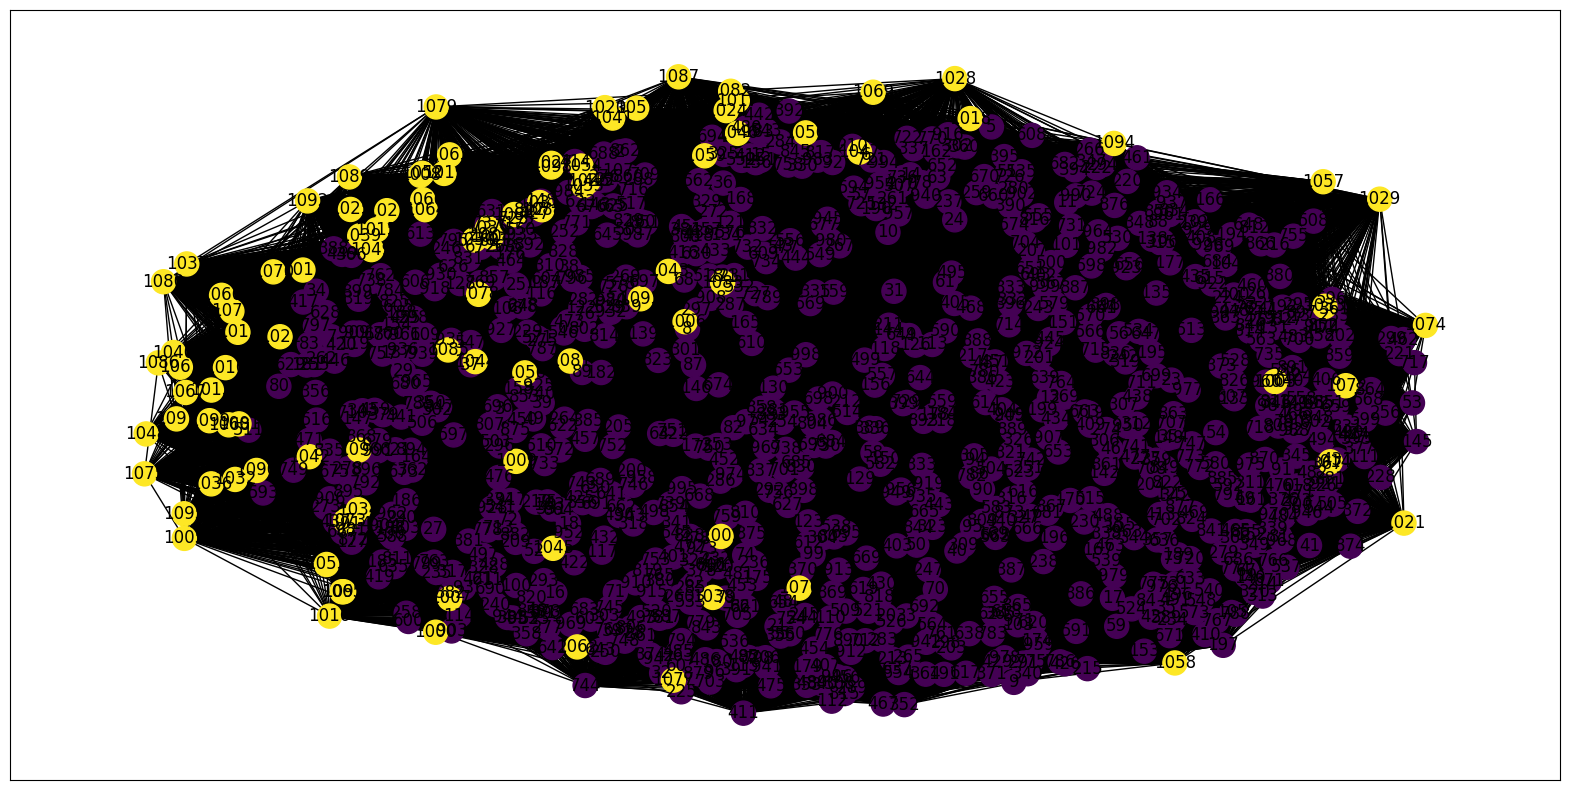

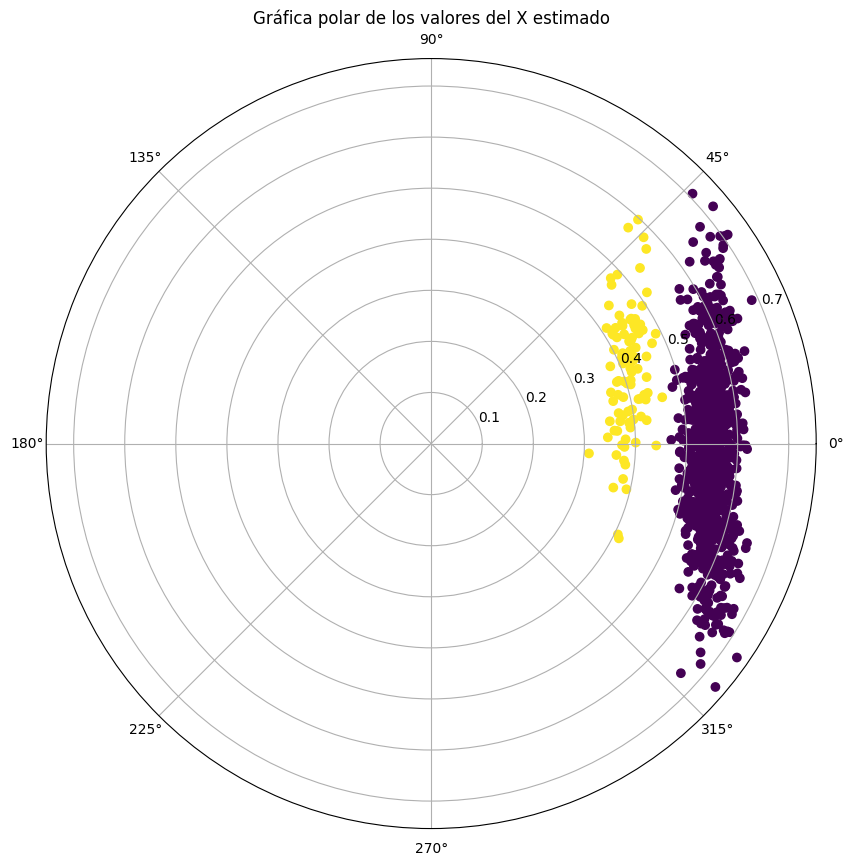

<Figure size 640x480 with 0 Axes>

In [192]:
#####################################
# algunos ejemplos usando grafos SBM
#####################################

# repito el código de generación del grafo por comodidad en las pruebas.
# Sería interesante ver qué pasa con el grafo de la pregunta 3
# n = [100, 100]
n = [1000, 100]
# 3 comunidades
Q = [[0.3, 0.2], 
     [0.2, 0.3]]
# 4 comunidades
# Q = [[0.1, 0.02], [0.02, 0.1]]

# Wierd
# Q = [[0.9, 0.001], [0.001, 0.9]]

G_sbm = nx.stochastic_block_model(sizes=n, p=Q)
ase = gp.embed.AdjacencySpectralEmbed(n_elbows=2)
Xhat = ase.fit_transform(G_sbm)

# el algoritmo de clustering será entonces GMM
# se puede probar cambiar el máximo y mínimo número de clusters a ver qué pasa.
cluster_algo = gp.cluster.AutoGMMCluster(min_components=2, max_components=5)
clusters_hat = cluster_algo.fit_predict(Xhat)
print(print("Número de clusters: "+str(np.max(clusters_hat)-np.min(clusters_hat)+1)))

# ahora dibujo el grafo como siempre, pero cambiando el color de los nodos en función de la comunidad estimada
plt.figure(figsize=(20,10))
posfijas_layout = nx.spring_layout(G_sbm)
nx.draw_networkx(G_sbm,posfijas_layout,node_color=clusters_hat)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(10,10))
complejo = Xhat[:,0]+1j*Xhat[:,1]
ax.scatter(np.angle(complejo),np.abs(complejo), c=clusters_hat)
plt.title('Gráfica polar de los valores del X estimado')
plt.figure()


### Detectando comunidades en un ejemplo real

Ahora sí, un grafo real. Vamos a considerar los partidos jugados entre las selecciones de fútbol durante un año. Cada nodo del vector será una selección y habrá una arista cuando esos dos equipos jugaron al menos una vez en el año en cuestión. Primero vamos a armar el grafo (naturalmente usando `pandas`) y después calcular el embedding. El año se elige como variable.

In [193]:
# Cambio codificación a UTF-8 porque si no Colab da error
# Ver: https://github.com/googlecolab/colabtools/issues/3409
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [194]:
# Bajamos los archivos necesarios. Lo dejo en una celda aparte para no repetir la bajada cada vez.
!wget -O AllMatches.csv https://www.fing.edu.uy/owncloud/index.php/s/V2tk4MxZxAvNidx/download
!wget -O codigos_paises_corregido.csv https://www.fing.edu.uy/owncloud/index.php/s/gb7SIbuUzVOgQJj/download
!wget -O world.jpg https://www.fing.edu.uy/owncloud/index.php/s/ABbYDE4nR4T3qvx/download

df_matches = pd.read_csv('AllMatches.csv')
df_matches['anio'] = pd.to_datetime(df_matches.Date,format='%m/%d/%Y').dt.year
df_matches.head()

--2025-09-27 17:47:21--  https://www.fing.edu.uy/owncloud/index.php/s/V2tk4MxZxAvNidx/download
Resolving www.fing.edu.uy (www.fing.edu.uy)... 164.73.32.20
Connecting to www.fing.edu.uy (www.fing.edu.uy)|164.73.32.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3195705 (3.0M) [text/csv]
Saving to: ‘AllMatches.csv’

AllMatches.csv      100%[===================>]   3.05M  --.-KB/s    in 0.1s    

2025-09-27 17:47:22 (23.8 MB/s) - ‘AllMatches.csv’ saved [3195705/3195705]

--2025-09-27 17:47:22--  https://www.fing.edu.uy/owncloud/index.php/s/gb7SIbuUzVOgQJj/download
Resolving www.fing.edu.uy (www.fing.edu.uy)... 164.73.32.20
Connecting to www.fing.edu.uy (www.fing.edu.uy)|164.73.32.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9699 (9.5K) [text/csv]
Saving to: ‘codigos_paises_corregido.csv’

codigos_paises_corr 100%[===================>]   9.47K  --.-KB/s    in 0s      

2025-09-27 17:47:22 (80.4 MB/s) - ‘codigos_paises_corregido.c

Date  HomeTeam  AwayTeam  GoalsHome  GoalsAway Tournament     Venue  \
0  11/30/1872  Scotland   England          0          0   Friendly  Scotland   
1    3/8/1873   England  Scotland          4          2   Friendly   England   
2    3/7/1874  Scotland   England          2          1   Friendly  Scotland   
3    3/6/1875   England  Scotland          2          2   Friendly   England   
4    3/4/1876  Scotland   England          3          0   Friendly  Scotland   

   RatingHome  RatingAway  RankHome  RankAway  NeutralVenue  Unnamed: 12  \
0        1797        1803         2         1         False          NaN   
1        1814        1786         1         2         False          NaN   
2        1794        1806         2         1         False          NaN   
3        1803        1797         1         2         False          NaN   
4        1810        1790         1         2         False          NaN   

   Unnamed: 13  anio  
0          NaN  1872  
1          NaN  1873  
2          NaN  1874  
3          NaN  1875  
4          NaN  1876

Dimensiones elegidas (con pesos): 5
Dimensiones elegidas (sin pesos): 3


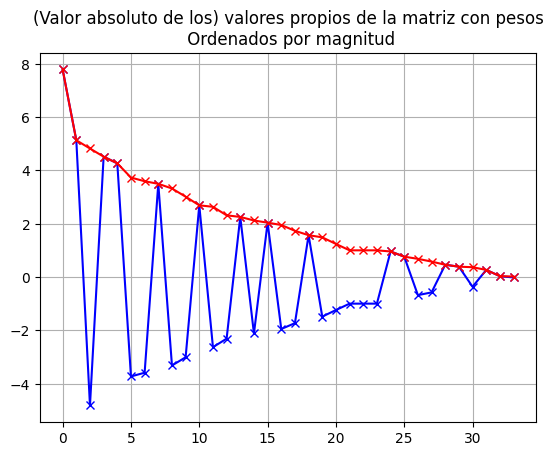

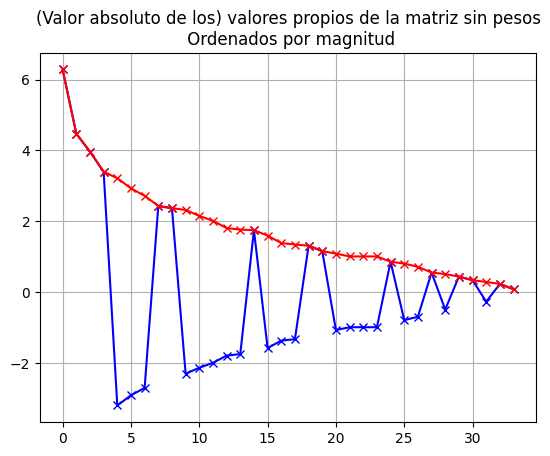

In [230]:
anio = 1950
df_matches_recortado = df_matches[df_matches.anio==anio]

# voy a contar cuántos partidos hubo entre las selecciones, sin importar dónde se jugó ni quién fue local.
ordered_matches = pd.DataFrame(df_matches_recortado[['HomeTeam','AwayTeam']].apply(lambda x: sorted([x['HomeTeam'],x['AwayTeam']]),axis=1).tolist())
ordered_matches.columns = ['team1','team2']
num_matchs = ordered_matches.groupby(['team1','team2']).size().reset_index()
num_matchs.columns = ['team1','team2','weight']

# voy a armar dos versiones del grafo: uno con pesos (la cantidad de partidos) y otro sin
G_sin_pesos = nx.from_pandas_edgelist(num_matchs,source='team1',target='team2',create_using=nx.Graph())
G_con_pesos = nx.from_pandas_edgelist(num_matchs,source='team1',target='team2',edge_attr='weight',create_using=nx.Graph())

# me quedo con la componente conexa. No tiene sentido detectar comunidades en un grafo disconexo.
G_sin_pesos = gp.utils.largest_connected_component(G_sin_pesos)
G_con_pesos = gp.utils.largest_connected_component(G_con_pesos)

# hago el embedding
ase = gp.embed.AdjacencySpectralEmbed(n_elbows = 2)
# CUIDADO: lo mejor es pasarle un array al embedder de graspologic.
# Sino el orden de los nodos a veces no se respeta.
Xhat_con_pesos = ase.fit_transform(nx.to_numpy_array(G_con_pesos))
Xhat_sin_pesos = ase.fit_transform(nx.to_numpy_array(G_sin_pesos))

# calculo los valores propios de A y los ordeno por magnitud (y en caso de empate, por signo).
w = np.linalg.eigvals(nx.to_numpy_array(G_con_pesos))
wabs = np.array(list(zip(-np.abs(w), -np.sign(np.real(w)))), dtype=[('abs', 'f4'), ('sign', 'i4')])
w = w[np.argsort(wabs,order=['abs','sign'])]
plt.plot(w,'x-', color='blue')
plt.plot(np.abs(w),'x-', color='red')
plt.title('(Valor absoluto de los) valores propios de la matriz con pesos\n Ordenados por magnitud')
plt.grid()

w = np.linalg.eigvals(nx.to_numpy_array(G_sin_pesos))
wabs = np.array(list(zip(-np.abs(w), -np.sign(np.real(w)))), dtype=[('abs', 'f4'), ('sign', 'i4')])
w = w[np.argsort(wabs,order=['abs','sign'])]
plt.figure()
plt.plot(w,'x-', color='blue')
plt.plot(np.abs(w),'x-', color='red')
plt.title('(Valor absoluto de los) valores propios de la matriz sin pesos\n Ordenados por magnitud')
plt.grid()

print("Dimensiones elegidas (con pesos): "+str(Xhat_con_pesos.shape[1]))
print("Dimensiones elegidas (sin pesos): "+str(Xhat_sin_pesos.shape[1]))


Ahora vamos a calcular el clustering de las selecciones. Para hacernos una idea de qué esperar, y como no podemos dibujar un vector de dimensión>3, vamos a usar el método [T-distributed stochastic neighbor embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (TSNE) para reducir su dimensión y plotear los $\hat{\mathbf{x}}_i$ en el plano. La idea es obtener una visualización donde vectores similares están cerca.

13. De la visualización debería estar claro que el grafo con pesos se podrá agrupar más "fácilmente". ¿Porqué cree que sucede esto?

Text(0.5, 1.0, 'TSNE para el embedding del grafo sin pesos')

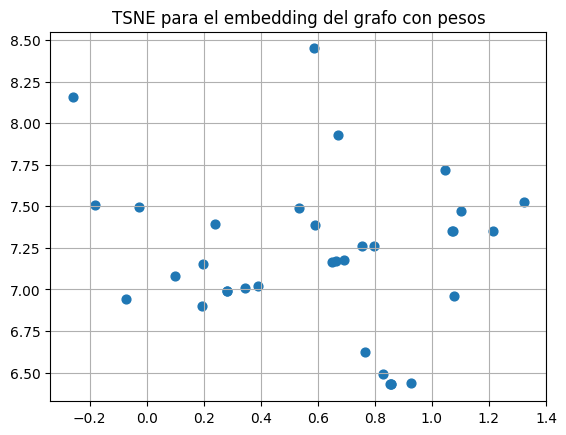

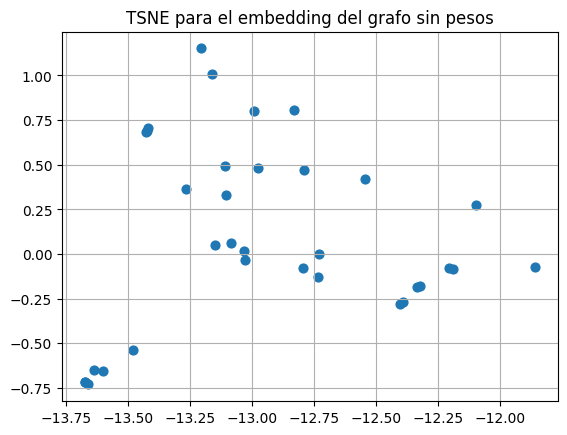

In [231]:
Xtsne_con = TSNE(n_components=2).fit_transform(Xhat_con_pesos)
plt.figure()
plt.scatter(Xtsne_con[:, 0],Xtsne_con[:, 1], s=40);
plt.grid()
plt.title('TSNE para el embedding del grafo con pesos')

Xtsne_sin = TSNE(n_components=2).fit_transform(Xhat_sin_pesos)
plt.figure()
plt.scatter(Xtsne_sin[:, 0],Xtsne_sin[:, 1], s=40);
plt.grid()
plt.title('TSNE para el embedding del grafo sin pesos')



Text(0.5, 1.0, 'TSNE para el embedding del grafo sin pesos')

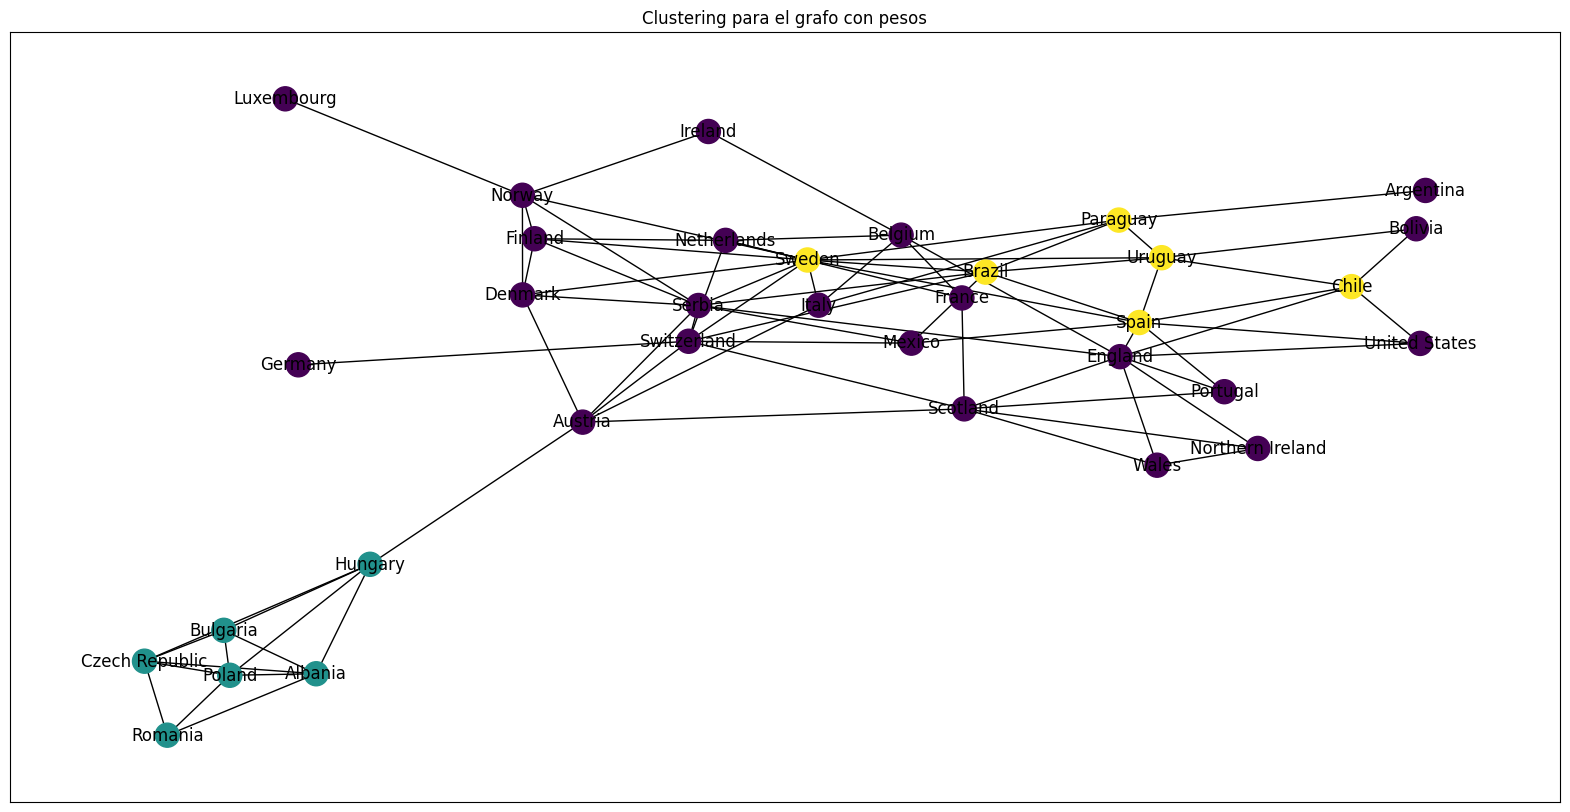

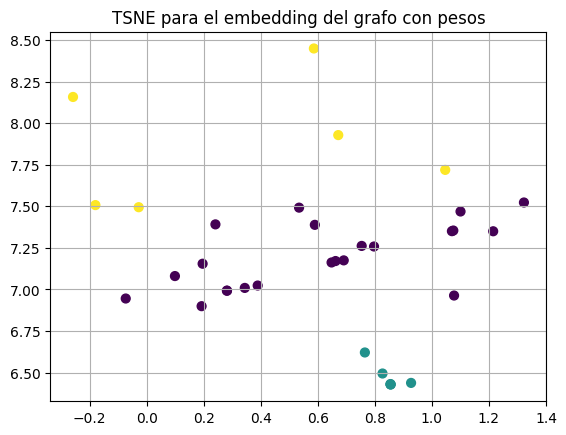

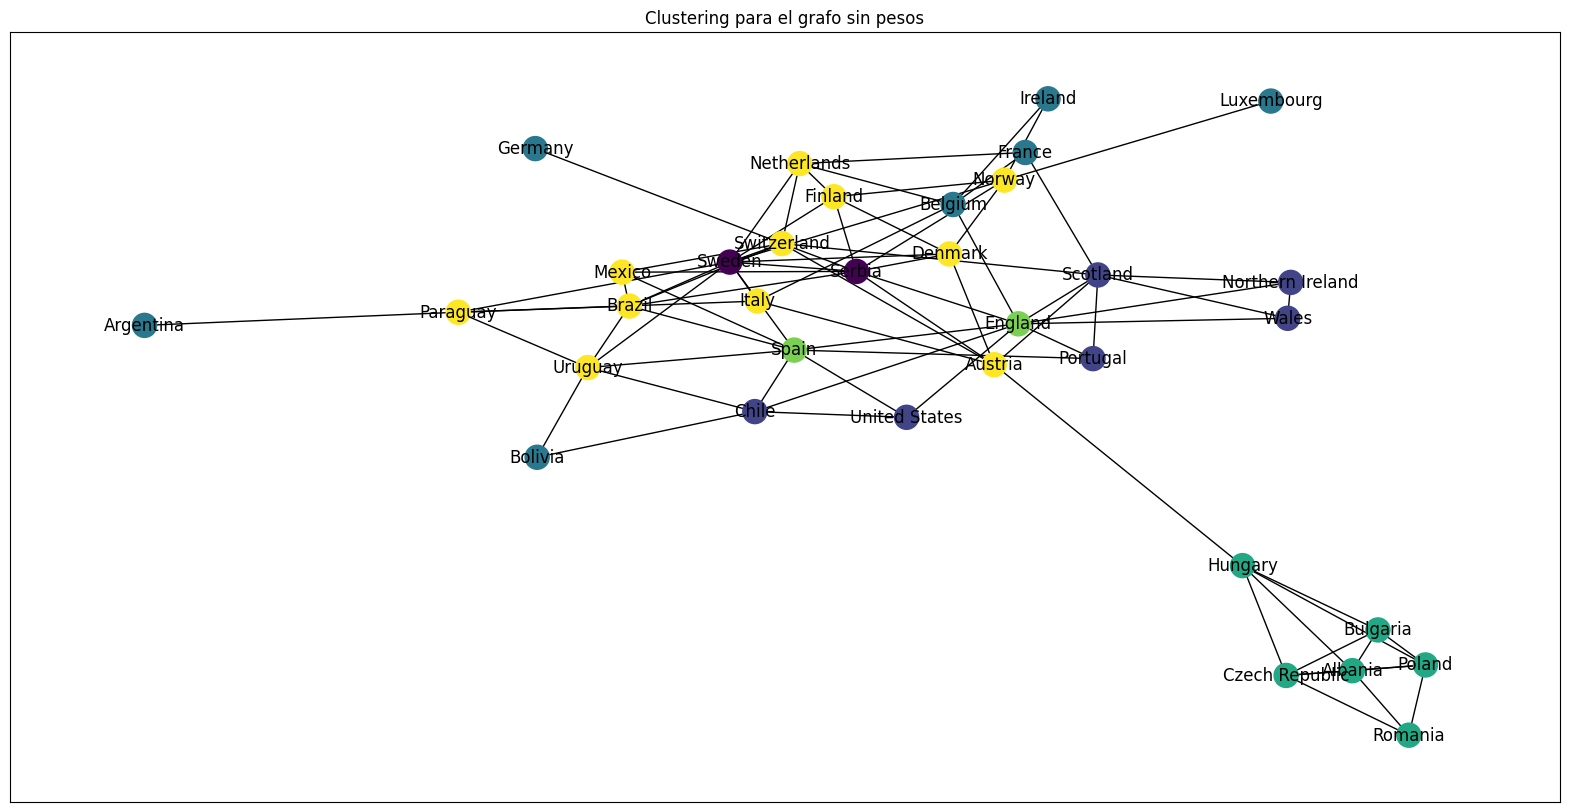

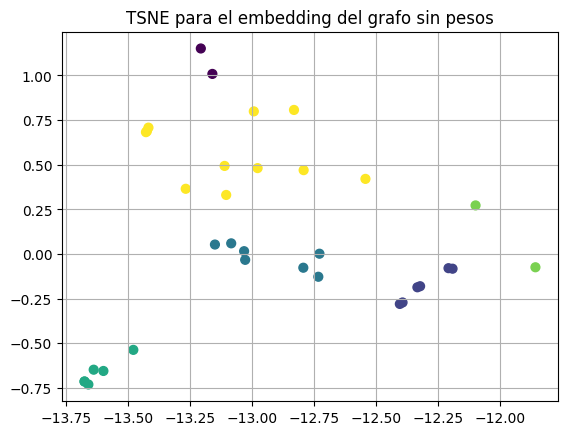

In [232]:
###############################################
# Ahora sí, a calcular y dibujar el clustering!
###############################################
cluster_algo = gp.cluster.AutoGMMCluster(min_components=1, max_components=6)

clusters_hat_con_pesos = cluster_algo.fit_predict(Xhat_con_pesos)
clusters_hat_sin_pesos = cluster_algo.fit_predict(Xhat_sin_pesos)

# empecemos dibujando el grafo con los colores de cada comunidad detectada en los nodos y el TSNE para ver si cierra con lo anterior
plt.figure(figsize=(20,10))
nx.draw_networkx(G_con_pesos,node_color=clusters_hat_con_pesos, with_labels=True)
plt.title('Clustering para el grafo con pesos')
plt.figure()
plt.scatter(Xtsne_con[:, 0],Xtsne_con[:, 1], c=clusters_hat_con_pesos, s=40, cmap='viridis');
plt.grid()
plt.title('TSNE para el embedding del grafo con pesos')

plt.figure(figsize=(20,10))
nx.draw_networkx(G_sin_pesos,node_color=clusters_hat_sin_pesos, with_labels=True)
plt.title('Clustering para el grafo sin pesos')
plt.figure()
plt.scatter(Xtsne_sin[:, 0],Xtsne_sin[:, 1], c=clusters_hat_sin_pesos, s=40, cmap='viridis');
plt.grid()
plt.title('TSNE para el embedding del grafo sin pesos')


### Finalmente, algo más vistoso para dibujar el grafo: en un mapa!

Siéntase libre de probar distintos años y tratar de explicar las comunidades detectadas por el algoritmo, tanto en el grafo con o sin pesos.


Text(0.5, 1.0, 'Clustering para el grafo sin pesos')

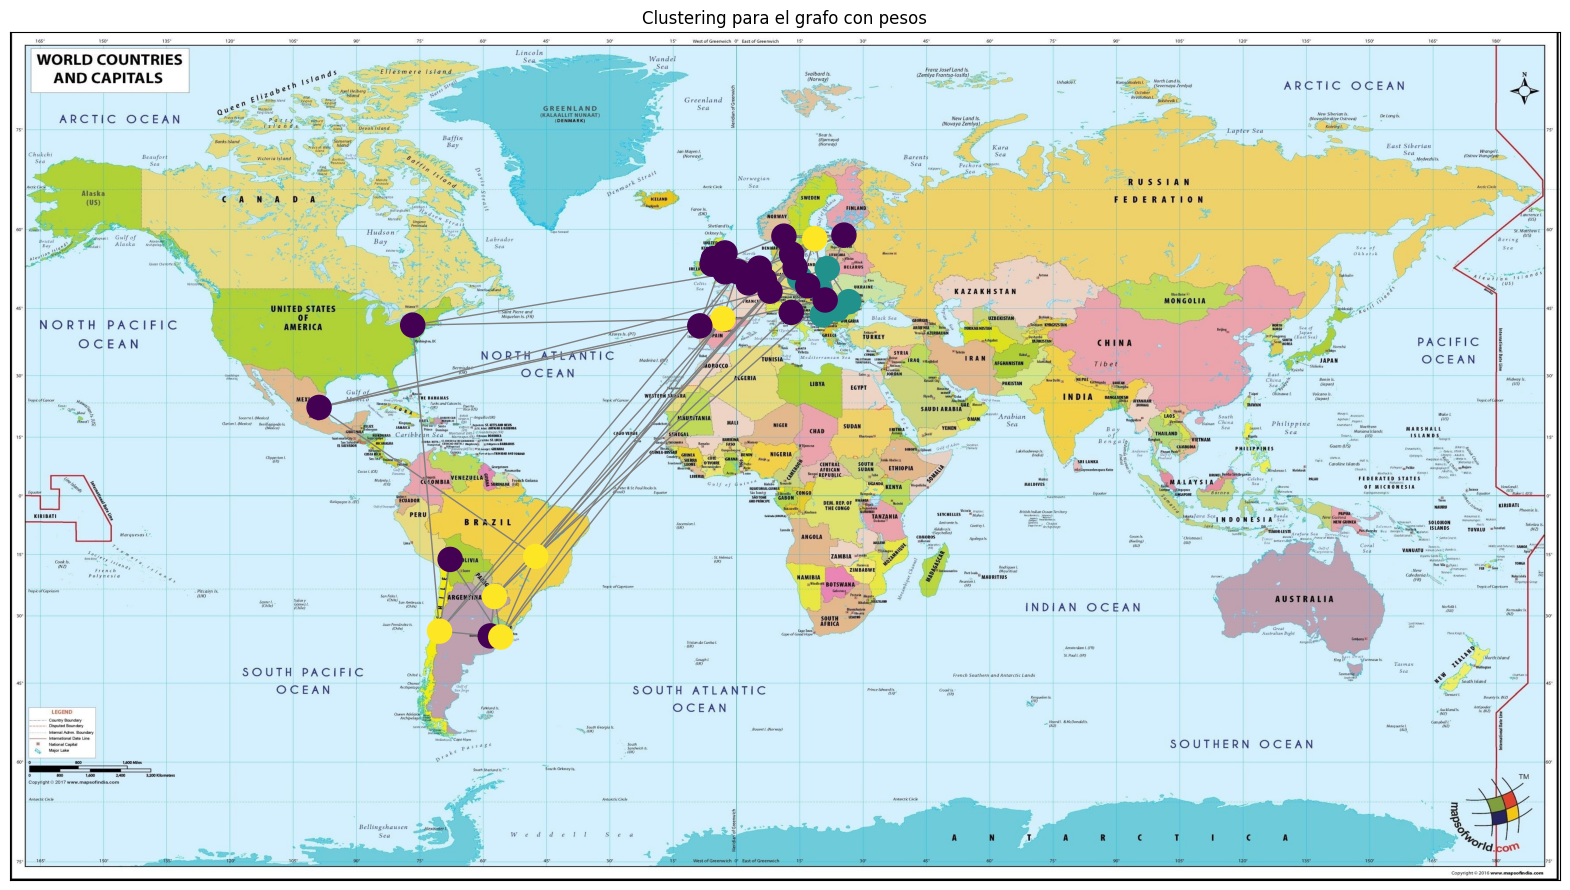

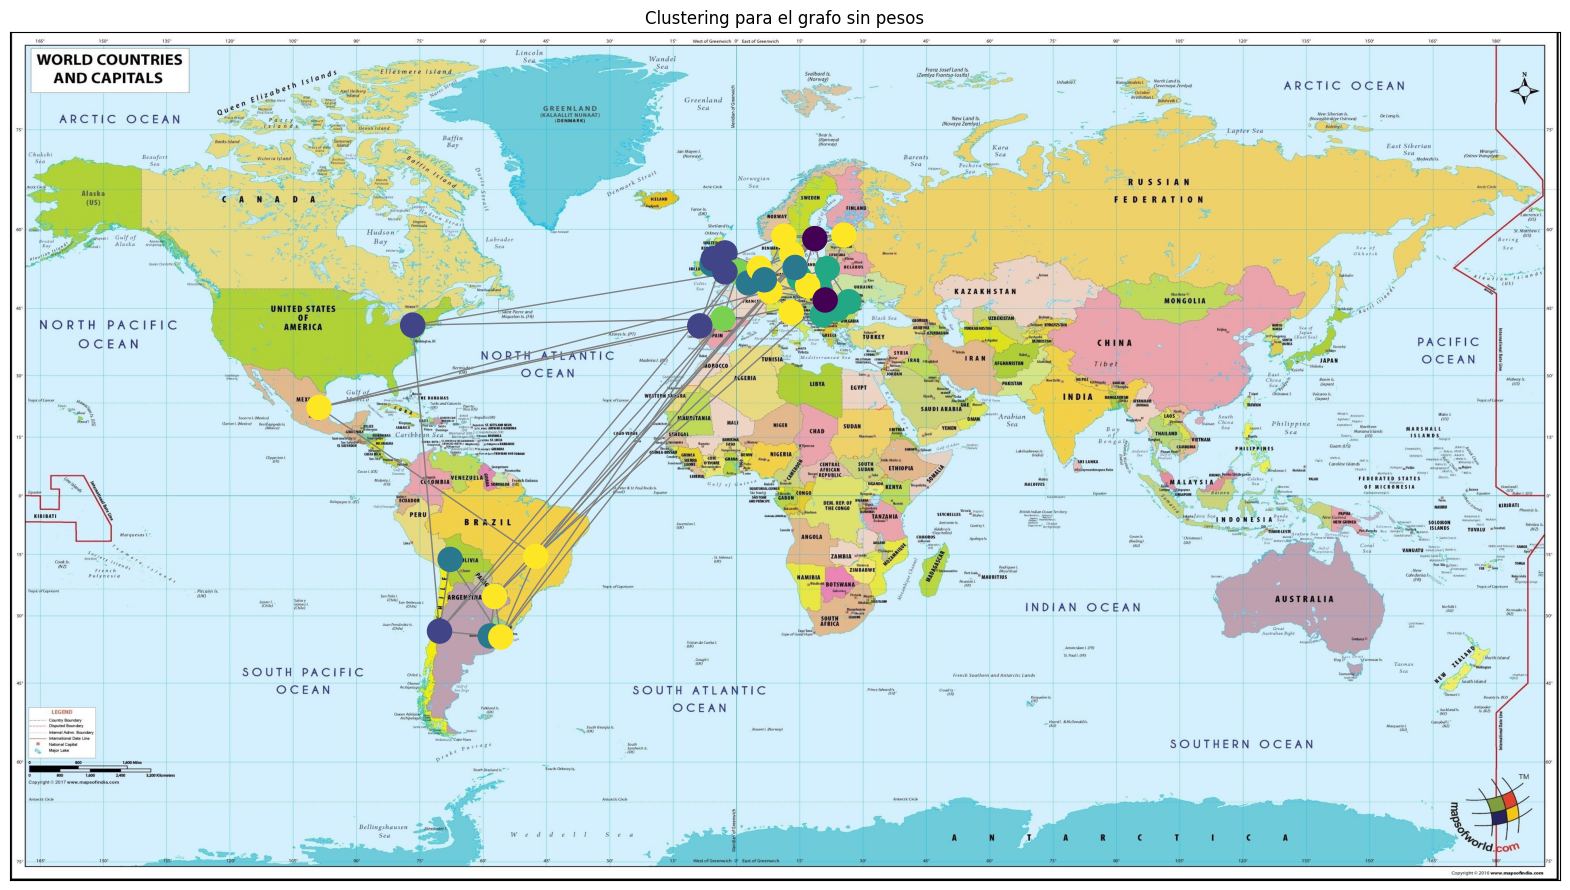

In [233]:
codigos = pd.read_csv('codigos_paises_corregido.csv')
# la tabla tiene las coordenadas de las capitales de los países.
xrange = (np.min(codigos.Capitallongitude),np.max(codigos.Capitallongitude))
yrange = (np.min(codigos.Capitallatitude),np.max(codigos.Capitallatitude))

# en el mapa que voy a usar, algunos países de oceanía están con una longitud distinta de mi tabla. Los corrijo:
codigos.loc[codigos.Capitallongitude<-170,'Capitallongitude']=codigos.loc[codigos.Capitallongitude<-170,'Capitallongitude'] + 170+189

# para fijar las posiciones de los nodos en un grafo, necesito armar un diccionario
# con key el nombre del nodo (en este caso el pais), y valor un array de dos elementos.
posix = codigos.set_index('Countryname')[['Capitallongitude','Capitallatitude']]
posix['arrays'] = list(posix.values)
posfijas = posix['arrays'].to_dict()

plt.figure(figsize=(20,20))
img = plt.imread("world.jpg")
plt.imshow(img, extent=[xrange[0]+3, xrange[1]+15, yrange[0]-38, yrange[1]+30])
nx.draw_networkx_nodes(G_con_pesos,posfijas,node_color=clusters_hat_con_pesos)
nx.draw_networkx_edges(G_con_pesos,posfijas,edge_color='grey')
plt.title('Clustering para el grafo con pesos')

plt.figure(figsize=(20,20))
img = plt.imread("world.jpg")
plt.imshow(img, extent=[xrange[0]+3, xrange[1]+15, yrange[0]-38, yrange[1]+30])
nx.draw_networkx_nodes(G_sin_pesos,posfijas,node_color=clusters_hat_sin_pesos)
nx.draw_networkx_edges(G_sin_pesos,posfijas,edge_color='grey')
plt.title('Clustering para el grafo sin pesos')